# Quora question pairs classification problem
## summary:
#### The dataset explored in this data set is the Quora question pairs dataset available on Kaggle. The problem is classifying duplicate questions. to flag them as duplicate or merge them with the original question

In [1]:
import pandas as pd
import numpy as np

first, we read the data

In [2]:
data_all = pd.read_csv('train.csv')
data_all.head()
data = data_all.sample(frac=1)

In [3]:
print("The data contains {} examples.".format(len(data)))
counts = data.is_duplicate.value_counts()
print("We have {} duplicate pairs and {} non-duplicate pairs".format(counts[1], counts[0]))
print("duplicate ratio is {:.2f}, more than one third of the data".format(counts[1]/ counts.sum()))

The data contains 404290 examples.
We have 149263 duplicate pairs and 255027 non-duplicate pairs
duplicate ratio is 0.37, more than one third of the data


from this very simple analysis, it appears that the data is unbalanced. we should keep that in mind

but first, since this is text data, we have to decide on what preprocessing steps we are going to use
for this project i've decided to use the usual tokenization-stemming steps, but i've found that the models perform slightly better with char-level analyzers on un-stemmed data.

In [4]:
import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')



def clean_question(text):
    
    words = tokenizer.tokenize(text.lower())
    #words = [porter.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data.question1 = data.question1.astype(str).apply(clean_question)
data.question2 = data.question2.astype(str).apply(clean_question)

In [6]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
224462,224462,984,43475,how should i study,how can i make my study more effective,1
163985,163985,254927,254928,are there jobs that combine trend forecasting ...,i am starting university this fall i intend to...,0
199647,199647,301192,301193,how do i know if i am a pervert or stalker,how do i know if i am a pervert,0
243290,243290,355695,355696,have any of the catholic church s doctrines ev...,why do some catholics lobby to change the chur...,0
31989,31989,58932,58933,why do digital circuits have to be binary,can someone really read binary computer code,0


as we can see, the data mainly consists of the two questions' text and a label

so far we've only removed symbols and punctuation, and converted all text to lowercase

In [7]:
data = data.dropna()
all_text = np.append(data.question1.values, data.question2.values)

As i mentioned earlier, working with char-level tf-idf vectorization gave me some accuracy and f1-score gains (around 5%)
The idea being, tf-idf works slightly better than word counts since I chose to keep stop words, and char-level tokenization is better.

however, this means we can use much larger n-grams

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(1,6), max_features=30000)
vect.fit(all_text)

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\feature_extraction\text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(analyzer='char', max_features=30000, ngram_range=(1, 6),
                token_pattern='\\w{1,}')

Since the dataset consists of question pairs and a label, I'm stacking the features for both question vertically to create a single feature vector for each example

In [9]:
q1_feats = vect.transform(data.question1.values)
q2_feats = vect.transform(data.question2.values)
y = data.is_duplicate.values

In [10]:
import scipy as sp
features = sp.sparse.hstack([q1_feats, q2_feats])
features.shape

(404290, 60000)

The new dimenion is (# of examples, 60000) since the vectorizer produces 30000 features for every question

It's also useful to use dimensionality reduction to get a smaller representation of our now-huge data.
note that the vectors produced by the scikit-learn vectorizer are sparse.
However, the result of the Truncated SVD dimensinality reduction is a dense representation, meaning we can use it later with models that don't support sparse matrices

In [24]:
from sklearn.decomposition import TruncatedSVD

dim_reducer = TruncatedSVD(n_components=50)
reduced_features = dim_reducer.fit_transform(features)

Since the data is unbalanced, it's useful to calculate the ratio between negative and positive examples, to use it later as a positive example weight

In [11]:
class_counts = data.is_duplicate.value_counts()
pos_class_weight = class_counts[0] / class_counts[1]

The two models i tried are the XGboost classifier and logistic regression, Logistic regression is mostly used here as a baseline for performance. while the sepcific parameters used to tune the XGboost model are a result of numerous expirements i meade.

In [12]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bytree=0.8, 
                        eta=0.5, gamma=1, gpu_id=0, learning_rate=0.2, max_depth=60, n_estimators=120,
                        reg_alpha=50,reg_lambda=50,scale_pos_weight=pos_class_weight,subsample=0.7)
                        
lr_clf = LogisticRegression(max_iter = 1000, class_weight='balanced')

Since the data is quite large (nearly half a million examples) it's okay to use a small subset for testing

Now, to split the data and test the models.

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = .01)

In [14]:
lr_clf.fit(x_train, y_train)
xgb_clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.5, gamma=1,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=60,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=120, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=50, reg_lambda=50, scale_pos_weight=1.708574797505075,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [15]:
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix

print("XGBoost training accuracy: ", accuracy_score(y_train, xgb_clf.predict(x_train)))
print("Logistic regression training accuracy: ", accuracy_score(y_train, xgb_clf.predict(x_train)))

XGBoost training accuracy:  0.9869930318028617
Logistic regression training accuracy:  0.9869930318028617


In [16]:
y_pred_xgb = xgb_clf.predict(x_test)
y_pred_lr = lr_clf.predict(x_test)

In [17]:
print("XGBoost testing accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("Logistic regression testing accuracy: ", accuracy_score(y_test, y_pred_lr))

XGBoost testing accuracy:  0.8444224585703686
Logistic regression testing accuracy:  0.7529062577294089


In [18]:
print("XGBoost testing f1-score: ", f1_score(y_test, y_pred_xgb))
print("Logistic regression testing f1-score: ", f1_score(y_test, y_pred_lr))

XGBoost testing f1-score:  0.7910993025572899
Logistic regression testing score:  0.6867356538099718


XGBoost confusion matrix


Text(0.5, 0.98, 'XGBoost Confusion Matrix')

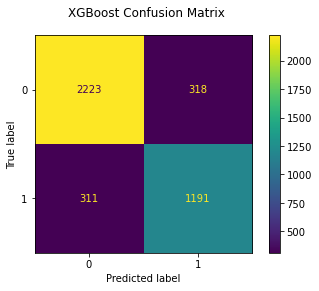

In [19]:
print("XGBoost confusion matrix")
disp = plot_confusion_matrix(xgb_clf, x_test, y_test)
disp.figure_.suptitle("XGBoost Confusion Matrix")

Logistic Regression confusion matrix


Text(0.5, 0.98, 'Logistic Regression Confusion Matrix')

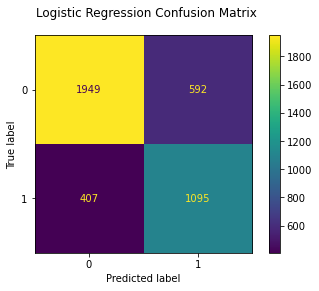

In [20]:
print("Logistic Regression confusion matrix")
disp = plot_confusion_matrix(lr_clf, x_test, y_test)
disp.figure_.suptitle("Logistic Regression Confusion Matrix")

as expected, the XGBoost model performs better at 84%, keeping a good f1-score and a balanced confusion matrix. although there's some overfitting to the training set

next, we save the vectorizer and the model, and try some other models.

In [23]:
import pickle

pickle.dump(vect, open("tfidf.pickle", "wb"))
pickle.dump(xgb_clf, open("xgboost_84.pickle", "wb"))


First, let's try a simple deep neural network on the truncated svd data

In [25]:
from tensorflow import keras as K
from tensorflow.keras.preprocessing.text import Tokenizer

model = K.Sequential()
model.add(K.layers.Dense(100, batch_input_shape = (None, reduced_features.shape[1])))
model.add(K.layers.Dense(10, 'tanh'))
model.add(K.layers.Dense(1, 'sigmoid'))

optimizer = K.optimizers.Adam(lr = .1)
model.compile(loss = 'binary_crossentropy', metrics=['acc'], optimizer = optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               5100      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 6,121
Trainable params: 6,121
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(reduced_features, y, epochs = 100, batch_size = 200000, validation_split = .1)

Train on 363861 samples, validate on 40429 samples
Epoch 1/100
363861/363861 [==============================] - 2s 6us/sample - loss: 0.7839 - acc: 0.5853 - val_loss: 1.5188 - val_acc: 0.3730
Epoch 2/100
363861/363861 [==============================] - 0s 0us/sample - loss: 1.2402 - acc: 0.3725 - val_loss: 0.6176 - val_acc: 0.6774
Epoch 3/100
363861/363861 [==============================] - 0s 0us/sample - loss: 0.6287 - acc: 0.6734 - val_loss: 0.6762 - val_acc: 0.6305
Epoch 4/100
363861/363861 [==============================] - 0s 0us/sample - loss: 0.6732 - acc: 0.6320 - val_loss: 0.6829 - val_acc: 0.6064
Epoch 5/100
363861/363861 [==============================] - 0s 0us/sample - loss: 0.6725 - acc: 0.6141 - val_loss: 0.6403 - val_acc: 0.6512
Epoch 6/100
363861/363861 [==============================] - 0s 0us/sample - loss: 0.6303 - acc: 0.6614 - val_loss: 0.6200 - val_acc: 0.6790
Epoch 7/100
363861/363861 [==============================] - 0s 1us/sample - loss: 0.6196 - acc: 0.6798

The performance after 100 epochs is worse than logistic regression. it appears we should try a more complex model that's geared towards text (or rather sequence) classification

Using keras, we first create a text tokenizer, and use it to transform our text data into a sequence of tokens

In [27]:
from tensorflow import keras as K
from tensorflow.keras.preprocessing.text import Tokenizer
MAX_LENGTH = 100
#NUM_WORDS = 50000
tokenizer = Tokenizer()

tokenizer.fit_on_texts(all_text)
vocab_size = len(tokenizer.word_index) + 1


Padding the sequences is necessary to later use them as input to an embedding layer

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

q1_seq = pad_sequences(tokenizer.texts_to_sequences(data.question1.values.astype(str)), maxlen = MAX_LENGTH)
q2_seq = pad_sequences(tokenizer.texts_to_sequences(data.question2.values.astype(str)), maxlen = MAX_LENGTH)

The model archticture proposed here is a simple one, Using an embedding layer and a bidirectional LSTM to extract features from both question sequences, then concatinating the outputs to feed-forward them into a dense layer that outputs a label

In [33]:
num_words = len(tokenizer.word_index) + 1
regularizer = K.regularizers.l1_l2(l1=1e-4, l2=1e-4)

Q1 = K.layers.Input((len(q1_seq[0])))
Q2 = K.layers.Input((len(q1_seq[0])))

embed_layer = K.layers.Embedding(vocab_size, 10)

lstm_layer = K.layers.Bidirectional(K.layers.LSTM(10, kernel_regularizer=regularizer))

dropout1 = K.layers.Dropout(0.5)
dropout2 = K.layers.Dropout(0.5)

dense = K.layers.Dense(1, kernel_regularizer=regularizer)
dense_features = K.layers.Dense(32)

out_layer = K.layers.Dense(1, activation='sigmoid')

def apply_stack(q):
    
    q = embed_layer(q)
    q = lstm_layer(q)
    q = dropout1(q)
    q = dense(q)
    q = dropout2(q)
    return q

conc_dense = K.layers.concatenate([apply_stack(Q1),
                                   apply_stack(Q2)])

output = out_layer(conc_dense)

model = K.Model(inputs = [Q1, Q2], outputs = [output])
optimizer = K.optimizers.Adam(
    learning_rate=.001,
    decay = 1e-6
)
model.compile(loss = 'binary_crossentropy', metrics=['acc'], optimizer = optimizer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 10)      862000      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20)           1680        embedding_1[0][0]          

In [34]:
early_stopping = K.callbacks.EarlyStopping(monitor ='val_loss', min_delta = 1e-4, patience = 3)

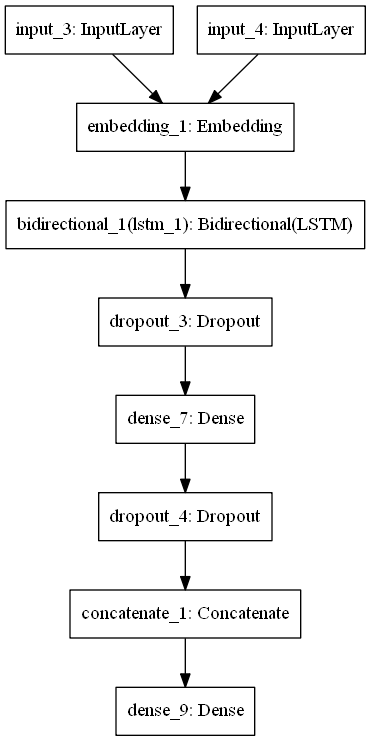

In [35]:
K.utils.plot_model(model)

as the diagram above shows, i'm using the same layers with the same weights to extract features from both questions, since questions are basically the same structure and information learned from one question can be applied to another.

Let's train this model and see how it performs

In [32]:
model.fit(x = [q1_seq, q2_seq],y= data.is_duplicate.values, batch_size = 5000, epochs = 10, validation_split = .01,
         validation_freq=1, callbacks = [early_stopping])

Train on 400247 samples, validate on 4043 samples
Epoch 1/10
400247/400247 [==============================] - 29s 71us/sample - loss: 0.6887 - acc: 0.6294 - val_loss: 0.6710 - val_acc: 0.6235
Epoch 2/10
400247/400247 [==============================] - 17s 43us/sample - loss: 0.6510 - acc: 0.6435 - val_loss: 0.6098 - val_acc: 0.6639
Epoch 3/10
400247/400247 [==============================] - 17s 42us/sample - loss: 0.6119 - acc: 0.6881 - val_loss: 0.5704 - val_acc: 0.7321
Epoch 4/10
400247/400247 [==============================] - 17s 42us/sample - loss: 0.5917 - acc: 0.7053 - val_loss: 0.5525 - val_acc: 0.7482
Epoch 5/10
400247/400247 [==============================] - 17s 42us/sample - loss: 0.5759 - acc: 0.7127 - val_loss: 0.5397 - val_acc: 0.7527
Epoch 6/10
400247/400247 [==============================] - 17s 42us/sample - loss: 0.5665 - acc: 0.7171 - val_loss: 0.5311 - val_acc: 0.7512
Epoch 7/10
400247/400247 [==============================] - 17s 43us/sample - loss: 0.5591 - acc: 

The model trained much faster than the XGBoost model, However. judging by the validation accuracy, it only did slightly better (about 1%) than the logistic regression model

In [ ]:
model.save('./simple_lstm_conv_no_batchnorm')